The objective of this notebook is to compare the performance of query_ball_point vs query_ball_tree to search the fixed neighbour queries.

While one requires both the queries and search space to be tree structures, other searches every point in the query using for loop.

First begin by testing for a single query, whether constructing a tree for it is worth the performance or not.

In [35]:
import numpy as np
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from collections import defaultdict
from tqdm import tqdm_notebook
from scipy.spatial import cKDTree
import itertools
from MDAnalysis.lib._cutil import unique_int_1d 

In [4]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [121]:
def tree_point(tree, query, radius):
    query = np.asarray(query)
    if query.shape == (3, ):
        query = query.reshape((1, 3))
    indices = list(tree.query_ball_point(query,radius))
    indices = np.array(list(itertools.chain.from_iterable(indices)),
                                     dtype=np.int)
    return unique_int_1d(indices)

In [117]:
def tree_tree(tree, query, radius):
    query = np.asarray(query)
    if query.shape == (3, ):
        query = query.reshape((1, 3))
    
    treeq = cKDTree(query, 10)
    indices = treeq.query_ball_tree(tree, radius)
    indices = np.array(list(itertools.chain.from_iterable(indices)), dtype=np.int64)
    return unique_int_1d(indices)

# check results

In [66]:
box = np.array([100, 100, 100, 90, 90, 90], dtype=np.float32)
NPoints = 1000
radius = 10

In [54]:
coords = get_coords(box, NPoints)

In [55]:
pkdtree = PeriodicKDTree(box=box)
pkdtree.set_coords(coords, cutoff=radius)

In [67]:
q1 = np.array([[1, 1, 1]])

In [68]:
indices_point = tree_point(pkdtree.ckdt, q1, radius)

In [69]:
len(indices_point)

5

In [70]:
indices_tree = tree_tree(pkdtree.ckdt, q1, radius)

In [71]:
len(indices_tree)

5

# Benchmark for single query

In [79]:
box = np.array([100, 100, 100, 90, 90, 90], dtype=np.float32)
NPoints = np.logspace(2, 5, num=10, dtype= np.int64)
radius = 4
query = np.array([1., 1., 1.])

In [84]:
results = defaultdict(list)

for n in tqdm_notebook(np.unique(NPoints)):
    coords =  get_coords(box, n)
    pkdtree = PeriodicKDTree(box=box)
    pkdtree.set_coords(coords, cutoff=radius)
    
    res = %timeit -q -o tree_point(pkdtree.ckdt, query, radius)
    results['point'].append(res.average)
    
    res = %timeit -q -o tree_tree(pkdtree.ckdt, query, radius)
    results['tree'].append(res.average)
    
    results['n'].append(n)

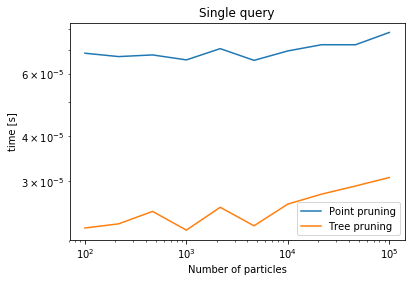

In [86]:
fig, axes = plt.subplots()

axes.plot(results['n'], results['point'], label="Point pruning")
axes.plot(results['n'], results['tree'], label="Tree pruning")
axes.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log', yscale='log', title='Single query')
axes.legend()

In [90]:
# Multiple Pruning
box = np.array([100, 100, 100, 90, 90, 90], dtype=np.float32)
NPoints = 40000
radius = 4

In [91]:
coords = get_coords(box, NPoints)

In [98]:
q = [coords[1:n+1] for n in range(1, 100)]

In [122]:
results = defaultdict(list)
i = 0
pkdtree = PeriodicKDTree(box=box)
pkdtree.set_coords(coords, cutoff=radius)

for n in tqdm_notebook(q):
    
    i = i+1
    res = %timeit -q -o tree_point(pkdtree.ckdt, n, radius)
    results['point'].append(res.average)
    
    res = %timeit -q -o tree_tree(pkdtree.ckdt, n, radius)
    results['tree'].append(res.average)
    
    results['n'].append(i)

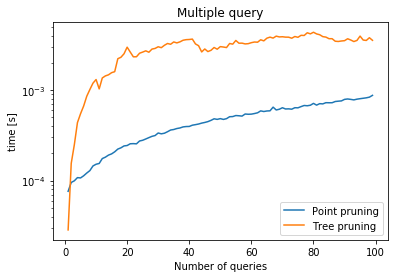

In [123]:
fig, axes = plt.subplots()

axes.plot(results['n'], results['point'], label="Point pruning")
axes.plot(results['n'], results['tree'], label="Tree pruning")
axes.set(xlabel='Number of queries', ylabel='time [s]', yscale='log', title='Multiple query')
axes.legend()

In [113]:
pkdtree = PeriodicKDTree(box=box)
pkdtree.set_coords(coords, cutoff=radius)